In [102]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)

#Tensorflow
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#Pandas
import pandas as pd 

#Keras
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Statistics Libraries
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
import math as m

#plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

#OverSampling
from imblearn.over_sampling import RandomOverSampler

#SKlearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

#global
import os, glob

import warnings
warnings.filterwarnings("ignore")

In [103]:
datasource_path = os.path.join(os.getcwd(), r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ', os.path.basename(file))

0   3C-EURUSD_FULL_1D_21F.csv
1   3C-EURUSD_FULL_1D_45F.csv
2   3C-EURUSD_FULL_1H_45F.csv
3   5C-EURUSD_FULL_1D_21F.csv
4   5C-EURUSD_FULL_1D_45F.csv
5   C-EURUSD_FULL_1D_21F.csv
6   C-EURUSD_FULL_1H_25F.csv
7   C-EURUSD_FULL_1H_45F.csv
8   C-EURUSD_FULL_1H_54F.csv


In [199]:
#SELECT an INDEX 
INDX = 4

CLASS_NUMBER = '5C'
MODEL_TYPE = 'LSTM'
FRECUENCIA = '1D'
TARGET_NAME = "Class"
ID = '01'

RANGE = 10
EPOCHS = 1
BATCH_SIZE = 32
TEST_SIZE = .20
VAL_SIZE = .10


In [105]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[INDX], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
NUM_FEATURES = DATASET.shape[1]
DATASET.head(2)

,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,S3,SO%k,SO%k1,SO%d2,Trix_5,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9,Class
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,...,1.235827,0.764402,0.764402,0.764402,0.0,0.0,0.0,0.0,24.730803,1.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,...,1.242020,0.578652,0.578652,0.625089,0.0,0.0,0.0,0.0,24.730803,2.0


In [106]:
SIZE = DATASET.shape[0]
SIZE

5137

In [200]:
#LOCATION TO SAVE
pwd = os.getcwd()
source_data_toSave = os.path.join(pwd, r'../../../Models/2020/LSTM/')
#print('Location to Save: ', source_data)
FILENAME = CLASS_NUMBER + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + str(SIZE) + 'Size_' + MODEL_TYPE + '_' + str(RANGE) + 'Range_' + str(EPOCHS) + 'Epochs' + '_' + TARGET_NAME + "_"+ ID 
file_name_toSave = FILENAME + '.hdf5'
print('FILENAME: ', FILENAME)
print('File Name Model:', file_name_toSave)


FILENAME:  5C_1D_45F_5137Size_LSTM_10Range_1Epochs_Class_01
File Name Model: 5C_1D_45F_5137Size_LSTM_10Range_1Epochs_Class_01.hdf5


In [202]:
test_results_csv = os.path.join(pwd, r'../../../Results/LSTM/' + FILENAME + '_Test.csv')
print(test_results_csv)
train_results_csv = os.path.join(pwd, r'../../../Results/LSTM/' + FILENAME + '_Train.csv')
print(train_results_csv)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/LSTM/5C_1D_45F_5137Size_LSTM_10Range_1Epochs_Class_01_Test.csv
/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/LSTM/5C_1D_45F_5137Size_LSTM_10Range_1Epochs_Class_01_Train.csv


In [108]:
HYPER_L1_IN = RANGE

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [109]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (5137, 45)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  ...  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03  ...   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05  ...   
std       0.122817     0.123571     0.121969     0.122813  5.3052

In [110]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(4938, 43)
      Open     High      Low    Close        Volume  Open_Bid  High_Bid  \
0  1.23655  1.23817  1.22801  1.23179  1.078729e+06   1.23639   1.23804   
1  1.23158  1.23241  1.22967  1.23109  8.212280e+04   1.23088   1.23231   
2  1.23140  1.23154  1.21310  1.21496  1.130388e+06   1.23124   1.23140   
3  1.21495  1.21669  1.20594  1.20711  1.123270e+06   1.21479   1.21656   
4  1.20718  1.21160  1.20519  1.20794  1.118725e+06   1.20702   1.21156   

   Low_Bid  Close_Bid   Volume_Bid  ...        S3      SO%k     SO%k1  \
0  1.22791    1.23169  1291823.750  ...  1.216983  0.372047  0.372047   
1  1.22955    1.23099    93508.000  ...  1.226963  0.518248  0.518248   
2  1.21298    1.21486  1348137.000  ...  1.189753  0.100868  0.100868   
3  1.20583    1.20701  1344214.000  ...  1.192387  0.108837  0.108837   
4  1.20504    1.20784  1355827.375  ...  1.198477  0.429017  0.429017   

      SO%d2    Trix_5  MACD_5_25  MACDsign_5_25  MACDdiff_5_25  \
0  0.465089  0.001033   0.007685 

In [111]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  4938
Start:  0


In [112]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc

print(DF_Full.shape)

(4938, 43)


In [113]:

total = DATASET.shape[0]
print('Total: ', total)

Total:  5137


In [114]:
DF_Full[TARGET_NAME][0:12]

0     0.0
1    -2.0
2    -2.0
3     0.0
4     1.0
5    -2.0
6     0.0
7     1.0
8     2.0
9     1.0
10   -1.0
11   -2.0
Name: Class, dtype: float64

### Generate VECTOR Y

In [115]:
#generate the VECTOR Y
uniques, ids = np.unique(DF_Full[TARGET_NAME], return_inverse=True)

#target_y = np_utils.to_categorical(DF_Full[TARGET_NAME],num_classes=5)
target_y = np_utils.to_categorical(ids,len(uniques))
print(ids)
print(uniques)
print(target_y)

[2 0 0 ... 3 3 2]
[-2. -1.  0.  1.  2.]
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [116]:
close_y = target_y
print(close_y[:10])   
#   [1. 0. 0. 0. 0.]   =  0
#   [0. 1. 0. 0. 0.]   =  1
#   [0. 0. 1. 0. 0.]   =   2 
#   [0. 0. 0. 1. 0.]   =  -2
#   [0. 0. 0. 0. 1.]   =  -1
close_y.shape

[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


(4938, 5)

### REMOVE COLUMNS 

In [117]:
#REMOVE CLASS FROM Data
print(DF_Full.shape)
DF_Full = DF_Full.drop(['Class'], axis = 1)
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
DF_Full.head()

(4938, 43)
(4938, 42)


,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,...,R3,S3,SO%k,SO%k1,SO%d2,Trix_5,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9
0,1.23655,1.23817,1.22801,1.23179,1.078729e+06,1.23639,1.23804,1.22791,1.23169,1291823.750,...,1.247463,1.216983,0.372047,0.372047,0.465089,0.001033,0.007685,0.006724,0.000960,24.895479
1,1.23158,1.23241,1.22967,1.23109,8.212280e+04,1.23088,1.23231,1.22955,1.23099,93508.000,...,1.235183,1.226963,0.518248,0.518248,0.500529,0.000707,0.006466,0.006673,-0.000206,24.537966
2,1.23140,1.23154,1.21310,1.21496,1.130388e+06,1.23124,1.23140,1.21298,1.21486,1348137.000,...,1.245073,1.189753,0.100868,0.100868,0.234088,-0.000051,0.001415,0.005621,-0.004206,24.630783
3,1.21495,1.21669,1.20594,1.20711,1.123270e+06,1.21479,1.21656,1.20583,1.20701,1344214.000,...,1.224637,1.192387,0.108837,0.108837,0.150587,-0.000975,-0.003743,0.003748,-0.007491,24.746555
4,1.20718,1.21160,1.20519,1.20794,1.118725e+06,1.20702,1.21156,1.20504,1.20784,1355827.375,...,1.217707,1.198477,0.429017,0.429017,0.336207,-0.001648,-0.006608,0.001677,-0.008285,24.668388


### SPLIT in 3 Sub Datasets

In [118]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.30000000000000004
count of Val and Test: 1541
end of train:  3596
count val:  513
count test:  1027
end_val 4109


In [119]:
close_y[:end_train,:]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [120]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y[:end_train,:]
data_val_y = close_y[end_train: end_val,:]
data_test_y = close_y[end_val:,:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (3596, 42)
data_val.shape:  (513, 42)
data_test.shape:  (829, 42)
data_training_y.shape:  (3596, 5)
data_val_y.shape:  (513, 5)
data_test_y.shape:  (829, 5)


In [121]:
data_test['Close'].head(10)

4109    1.17336
4110    1.17427
4111    1.17414
4112    1.18138
4113    1.18644
4114    1.18314
4115    1.18223
4116    1.18149
4117    1.17948
4118    1.17716
Name: Close, dtype: float64

In [122]:
uniques_data_test_y = uniques[data_test_y.argmax(1)]
uniques_data_test_y[:10]

array([ 1.,  0.,  2.,  2., -1., -1.,  0., -1., -1.,  1.])

### SCALAR

In [123]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.34423101 0.33894661 0.33438201 ... 0.57385074 0.39967666 0.42004268]
 [0.33519908 0.32853916 0.33743607 ... 0.57336787 0.37963807 0.35071301]
 [0.33487197 0.32696721 0.30695073 ... 0.56352136 0.31093976 0.36871221]
 ...
 [0.15359732 0.14964315 0.13827869 ... 0.65640364 0.45410909 0.58300109]
 [0.13960419 0.13504382 0.13860985 ... 0.65991417 0.40893634 0.55549692]
 [0.13673288 0.1325323  0.12245649 ... 0.65702066 0.36195187 0.56224193]]


(3596, 42)
[0.37669362 0.42690746 0.22466157 0.33182137 0.44717204 0.47414792
 0.30587499 0.43527102 0.48605834 0.61154273]


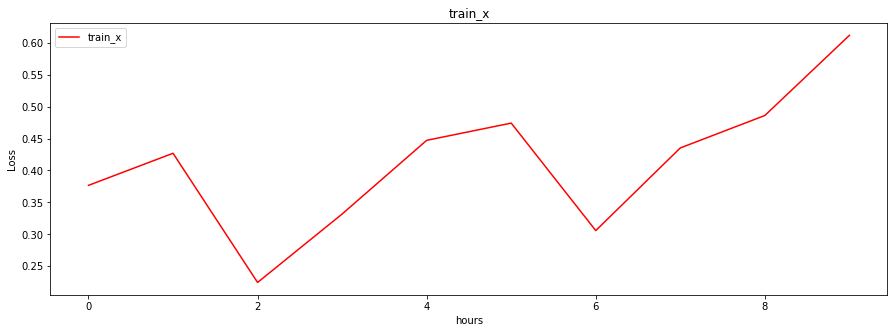

In [124]:
print(data_training_array_scaled.shape)
print(data_training_array_scaled[:10,12])
plt.figure(figsize=(15,5))
plt.plot(data_training_array_scaled[:10,12], color = 'red', label = 'train_x')
plt.title('train_x')
plt.xlabel('hours')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [125]:
data_training_y[:10]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

### CHART MA's

(3596, 42)


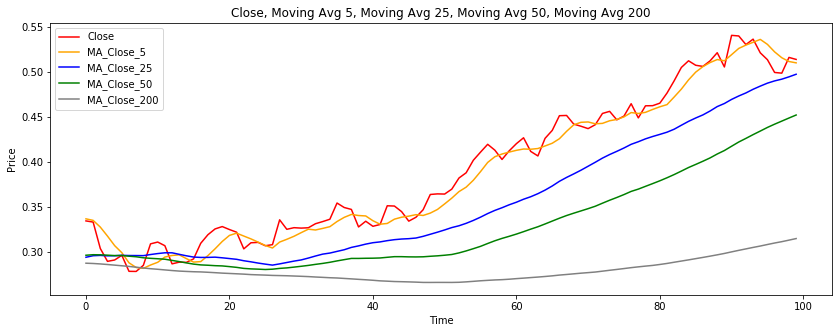

In [126]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3596, 42)


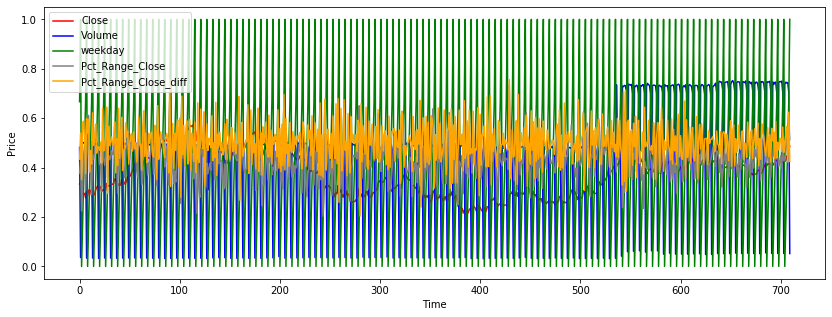

In [127]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3596, 42)


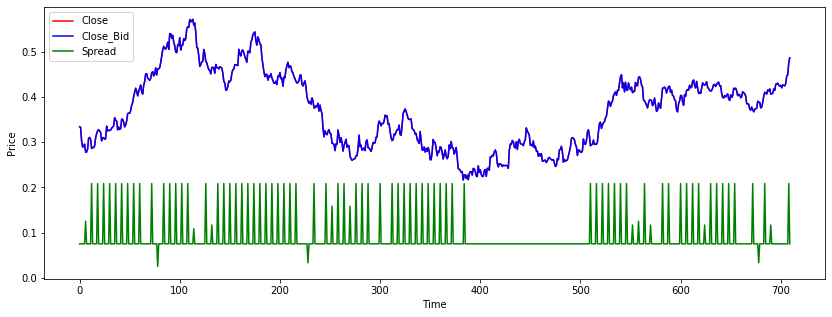

In [128]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [129]:
data_training_y

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

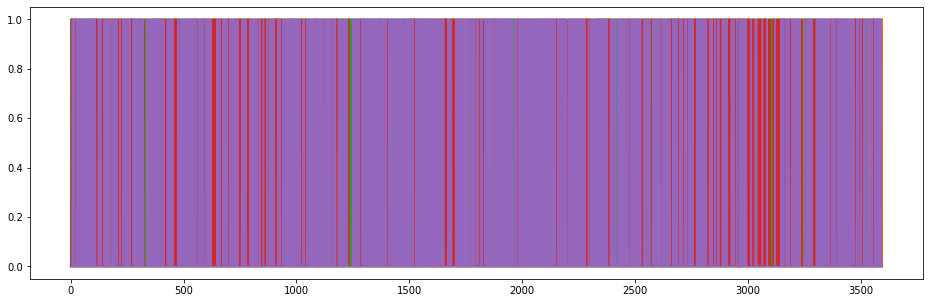

In [130]:
# Target para el entrenamiento
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [131]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    indx_start = i-RANGE
    X_train.append(data_training_array_scaled[indx_start:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(3586, 10, 42)
(3586, 5)


In [132]:
X_train_np[0,:,3]

array([0.33404984, 0.3327747 , 0.30339187, 0.2890921 , 0.29060405,
       0.29579569, 0.2779984 , 0.2778891 , 0.28466555, 0.30852885])

In [133]:
array = y_train_np[:RANGE]
uniques_y = uniques[array.argmax(1)]
print(uniques_y)

[-1. -2.  1.  0.  1.  2.  2.  1.  1. -1.]


In [134]:
#
#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
#print(data_val_x1.head)

(10, 42)
(513, 42)


(523, 42)

In [135]:
last_range_train_y = data_training_y[-RANGE:]
last_range_train_y

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [136]:
last_range_train_y.shape

(10, 5)

In [137]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y[-RANGE:]
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = np.concatenate((last_range_train_y,data_val_y))
print(data_val_y1.shape)
print(data_val_y1[:10])

(10, 5)
(513, 5)
(523, 5)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [138]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
#print(data_val_x2[:10])

(523, 42)

In [139]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    indx_start = i-RANGE
    X_val.append(data_val_x2[indx_start:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(513, 10, 42)
(513, 5)


In [140]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(10, 42)
(829, 42)


(839, 42)

In [141]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y[-RANGE:,:]
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = np.concatenate((last_range_training_y,data_test_y))
print(data_test_y1.shape)

(10, 5)
(829, 5)
(839, 5)


In [142]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
#print(data_test_x2[:10])

(839, 42)

In [143]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(829, 10, 42)
(829, 5)


In [144]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

10
42


### Oversampling Inbalanced Class

In [145]:
#Check Current Shape
print(X_train_np.shape)
print(y_train_np.shape)

(3586, 10, 42)
(3586, 5)


In [146]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample


In [147]:
#X_over, y_over = oversample.fit_resample(X_train_np, y_train_np)

### BUILD LSTM MODEL 

In [148]:
model = Sequential()
model.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
model.add(LSTM(units = 80, activation = 'relu'))
model.add(Dense(units = 5, activation = 'softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])


In [149]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 10)            2120      
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                29120     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 405       
Total params: 31,645
Trainable params: 31,645
Non-trainable params: 0
_________________________________________________________________


In [150]:
history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)

113/113 [==============================] - 1s 13ms/step - loss: 1.6074 - acc: 0.2089 - val_loss: 1.6133 - val_acc: 0.1949


In [151]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


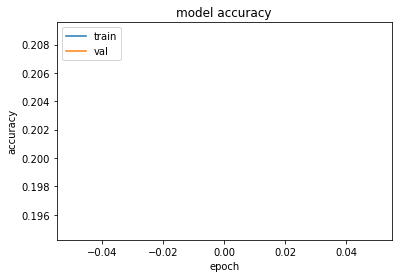

In [152]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

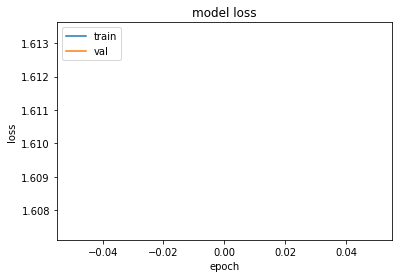

In [153]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [154]:
model.save(source_data_toSave + file_name_toSave)

In [155]:
#def baseline_model():
#    model.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#    model.add(LSTM(units = 5, activation = 'softmax'))
#    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])
#    #model.summary()
#    return model

In [156]:
#estimator = KerasClassifier(build_fn=baseline_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
#kfold = KFold(n_splits=2, shuffle=True)

In [157]:
#results = cross_val_score(estimator, X_train_np, y_train_np, cv=kfold)

In [158]:
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [159]:
#Model check pointer para almacenar el modelo cada epoca

#checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [160]:
#%%time
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)

#history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)





In [161]:
#PLOT MSE MAE

#plt.figure(figsize=(5,5))
#plt.plot(history.history['loss'], color = 'red', label = 'loss')
#plt.title('Loss Model')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [162]:
#PLOT MSE MAE
#plt.figure(figsize=(5,5))
#plt.plot(history.history['mean_squared_error'][:], color = 'green', label = 'MAPE')
#plt.title('Loss Model')
#plt.xlabel('Epochs')
#plt.ylabel('Loss - MSE')
#plt.legend()
#plt.show()


In [163]:
#Load Model
model = tf.keras.models.load_model(source_data_toSave + file_name_toSave)

In [164]:
def precision(label, confusion_matrix):
    #print('label',label)
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

### CONFUSION MATRIX TEST

In [165]:
#TEST
y_test_pred = model.predict(X_test_np)
print(X_test_np.shape)

print(y_test_pred.shape)
print(y_test_np.shape)

(829, 10, 42)
(829, 5)
(829, 5)


In [166]:
ID = 4
print(y_test_pred[ID])
print(y_test_np[:ID])

[0.22242865 0.1961021  0.16914321 0.1908435  0.2214826 ]
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [167]:
uniques_y_test_pred = uniques[y_test_pred.argmax(1)]
uniques_y_test_np = uniques[y_test_np.argmax(1)]
#print(uniques_y_test_pred)
print(uniques_y_test_pred.shape)
#print(uniques_y_test_np)
print(uniques_y_test_np.shape)

(829,)
(829,)


In [168]:
print(uniques)

[-2. -1.  0.  1.  2.]


In [169]:
conf_matrix_test = confusion_matrix(uniques_y_test_np, uniques_y_test_pred)
conf_matrix_test

array([[105,   0,   0,   0,  19],
       [163,   0,   0,   0,  32],
       [183,   0,   0,   0,  18],
       [172,   0,   0,   0,  14],
       [106,   0,   0,   0,  17]])

In [170]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_test):9.3f}    {recall(indx, conf_matrix_test):6.3f}")

indx Value Precision Recall
0
   -2        0.144     0.847
1
   -1          nan     0.000
2
    0          nan     0.000
3
    1          nan     0.000
4
    2        0.170     0.138


In [171]:
print("precision total:", precision_macro_average(conf_matrix_test))
print("recall total:", recall_macro_average(conf_matrix_test))

precision total: nan
recall total: 0.19699711513244164


In [172]:
accuracy(conf_matrix_test)

0.1471652593486128

### CONFUSION MATRIX TRAIN

In [173]:
#TRAIN
y_train_pred = model.predict(X_train_np)
print(X_train_np.shape)

print(y_train_pred.shape)
print(y_train_np.shape)

(3586, 10, 42)
(3586, 5)
(3586, 5)


In [174]:
ID = 4
print(y_train_pred[:ID])
print(y_train_np[:ID])

[[0.22226402 0.19385418 0.1701883  0.19001314 0.22368042]
 [0.22215435 0.19366175 0.17029074 0.19035944 0.2235338 ]
 [0.22119668 0.19351277 0.17138717 0.19097567 0.22292778]
 [0.22078575 0.19336338 0.17185763 0.19127871 0.22271453]]
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [175]:
uniques_y_train_pred = uniques[y_train_pred.argmax(1)]
uniques_y_train_np = uniques[y_train_np.argmax(1)]
print(uniques_y_train_pred)
print(uniques_y_train_pred.shape)
print(uniques_y_train_np)
print(uniques_y_train_np.shape)

[ 2.  2.  2. ... -2. -2. -2.]
(3586,)
[-1. -2.  1. ... -1. -2. -1.]
(3586,)


In [176]:
print(uniques)

[-2. -1.  0.  1.  2.]


In [177]:
conf_matrix_train = confusion_matrix(uniques_y_train_np, uniques_y_train_pred)
conf_matrix_train

array([[143,   0,   0,   0, 646],
       [102,   0,   0,   0, 598],
       [ 77,   0,   0,   0, 531],
       [ 83,   0,   0,   0, 609],
       [130,   0,   0,   0, 667]])

In [178]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_train):9.3f}    {recall(indx, conf_matrix_train):6.3f}")

indx Value Precision Recall
0
   -2        0.267     0.181
1
   -1          nan     0.000
2
    0          nan     0.000
3
    1          nan     0.000
4
    2        0.219     0.837


In [179]:
print("precision total:", precision_macro_average(conf_matrix_train))
print("recall total:", recall_macro_average(conf_matrix_train))

precision total: nan
recall total: 0.20362608196452797


In [180]:
accuracy(conf_matrix_train)

0.22587841606246514

### TEST RESULTS TO CSV

In [181]:
print("data_test.shape: ", data_test.shape)


data_test.shape:  (829, 42)


In [182]:
data_test_res = data_test
data_test_res.reset_index(drop=True, inplace=True)
results_data_test = pd.DataFrame(data_test_res['Open'])
results_data_test['High'] = data_test_res['High']
results_data_test['Low'] = data_test_res['Low']
results_data_test['Close'] = data_test_res['Close']
results_data_test['Volume'] = data_test_res['Volume']
print(results_data_test)

        Open     High      Low    Close       Volume
0    1.17145  1.17390  1.16697  1.17336  209621.9375
1    1.17319  1.17438  1.17308  1.17427    8920.6504
2    1.17427  1.17562  1.17198  1.17414  152661.7344
3    1.17412  1.18259  1.17408  1.18138  214738.0938
4    1.18135  1.18694  1.17955  1.18644  216994.3750
..       ...      ...      ...      ...          ...
824  1.09019  1.09960  1.08970  1.09787  221915.4388
825  1.09788  1.10311  1.09342  1.10169  339215.8879
826  1.10168  1.10937  1.09919  1.10782  290715.4826
827  1.10780  1.11452  1.10702  1.11071  330692.3901
828  1.11213  1.11217  1.11028  1.11158   10126.4174

[829 rows x 5 columns]


In [183]:
uniques_y_test_pred[:]

array([-2., -2., -2., -2., -2., -2., -2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2., -2.,  2.,  2.,  2.,  2., -2., -2., -2., -2.,  2.,  2.,
       -2., -2., -2., -2.,  2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

In [184]:

uniques_y_test_pred_pd = pd.DataFrame({'Real_Class': uniques_y_test_pred[:]})
print(uniques_y_test_pred_pd)

     Real_Class
0          -2.0
1          -2.0
2          -2.0
3          -2.0
4          -2.0
..          ...
824        -2.0
825        -2.0
826        -2.0
827        -2.0
828        -2.0

[829 rows x 1 columns]


In [185]:
results_data_test['Real_Class'] = uniques_y_test_np
results_data_test['Predicted_Class'] = uniques_y_test_pred_pd

In [186]:
results_data_test.head(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.17145,1.17390,1.16697,1.17336,209621.9375,1.0,-2.0
1,1.17319,1.17438,1.17308,1.17427,8920.6504,0.0,-2.0
2,1.17427,1.17562,1.17198,1.17414,152661.7344,2.0,-2.0
3,1.17412,1.18259,1.17408,1.18138,214738.0938,2.0,-2.0
4,1.18135,1.18694,1.17955,1.18644,216994.3750,-1.0,-2.0
5,1.18641,1.18799,1.18254,1.18314,204817.6406,-1.0,-2.0
6,1.18314,1.18750,1.18055,1.18223,199182.5000,0.0,-2.0
7,1.18150,1.18183,1.18059,1.18149,7389.2700,-1.0,2.0
8,1.18149,1.18199,1.17808,1.17948,187651.9063,-1.0,2.0
9,1.17946,1.17953,1.17362,1.17716,192445.1250,1.0,2.0


### Test Result Save CSV File 

In [188]:
#SAVE
results_data_test.to_csv(test_results_csv, header=True, index=False)

### TRAIN RESULTS TO CSV

In [189]:
print("data_train.shape: ", data_training.shape)


data_train.shape:  (3596, 42)


In [190]:
data_training_res = data_training
data_training_res.reset_index(drop=True, inplace=True)
results_data_train = pd.DataFrame(data_training_res['Open'])
results_data_train['High'] = data_training_res['High']
results_data_train['Low'] = data_training_res['Low']
results_data_train['Close'] = data_training_res['Close']
results_data_train['Volume'] = data_training_res['Volume']
print(results_data_train)
print(results_data_train.shape)
results_data_train = results_data_train.iloc[RANGE:]
results_data_train.reset_index(drop=True, inplace=True)
print(results_data_train.shape)

         Open     High      Low    Close        Volume
0     1.23655  1.23817  1.22801  1.23179  1.078729e+06
1     1.23158  1.23241  1.22967  1.23109  8.212280e+04
2     1.23140  1.23154  1.21310  1.21496  1.130388e+06
3     1.21495  1.21669  1.20594  1.20711  1.123270e+06
4     1.20718  1.21160  1.20519  1.20794  1.118725e+06
...       ...      ...      ...      ...           ...
3591  1.12887  1.13117  1.11607  1.12843  4.503077e+05
3592  1.12843  1.13765  1.12742  1.13165  4.213447e+05
3593  1.13165  1.13340  1.12142  1.12580  3.638887e+05
3594  1.12395  1.12532  1.12160  1.12237  1.277672e+04
3595  1.12237  1.12393  1.11282  1.11765  2.643780e+05

[3596 rows x 5 columns]
(3596, 5)
(3586, 5)


In [191]:
print(uniques_y_train_pred[:])
print(uniques_y_train_pred.shape)

[ 2.  2.  2. ... -2. -2. -2.]
(3586,)


In [192]:

uniques_y_train_pred_pd = pd.DataFrame({'Real_Class': uniques_y_train_pred[:]})
print(uniques_y_train_pred_pd)
print(uniques_y_train_pred_pd.shape)


      Real_Class
0            2.0
1            2.0
2            2.0
3            2.0
4            2.0
...          ...
3581        -2.0
3582        -2.0
3583        -2.0
3584        -2.0
3585        -2.0

[3586 rows x 1 columns]
(3586, 1)


In [193]:
results_data_train['Real_Class'] = uniques_y_train_np
results_data_train['Predicted_Class'] = uniques_y_train_pred_pd

In [194]:
results_data_train.head(10)
#results_data_train.tail(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.21754,1.22208,1.21466,1.21889,1.106444e+06,-1.0,2.0
1,1.21899,1.21999,1.21408,1.21666,1.132577e+06,-2.0,2.0
2,1.21663,1.21931,1.20414,1.20558,1.063896e+06,1.0,2.0
3,1.20628,1.20701,1.20509,1.20662,7.789710e+04,0.0,2.0
4,1.20657,1.20802,1.20459,1.20650,1.110041e+06,1.0,2.0
5,1.20640,1.21142,1.20518,1.20860,1.116064e+06,2.0,2.0
6,1.20851,1.21929,1.20256,1.21814,1.108055e+06,2.0,2.0
7,1.21808,1.22491,1.21587,1.22336,1.122153e+06,1.0,2.0
8,1.22333,1.23084,1.21984,1.22690,1.056604e+06,1.0,2.0
9,1.22640,1.22853,1.22591,1.22834,7.461340e+04,-1.0,2.0


In [195]:
uniques_y_train_np[:20]

array([-1., -2.,  1.,  0.,  1.,  2.,  2.,  1.,  1., -1., -1., -2.,  1.,
        0., -1.,  0.,  2., -2.,  1.,  0.])

### Test Result Save CSV File 

In [197]:
#Save
results_data_train.to_csv(train_results_csv, header=True, index=False)